# Hamiltonians

This is an example of plotting hamiltonians in phase space distributions.
First, create a simple line, a tracker and a particle set:

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np

np.random.seed(43543557)

In [ ]:
## Generate a simple 6-fold symmetric FODO lattice
n = 6
elements = []
for i in range(n):
    elements.extend(
        [
            xt.Drift(length=0.7),
            xt.Multipole(length=0.3, knl=[0, +0.63], ksl=[0, 0]),
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=0.4),
            xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))]),
            xt.Drift(length=0.3),
            xt.Multipole(length=0.3, knl=[0, -0.48], ksl=[0, 0]),  # -0.4
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=2.2),
        ][:: -1 if i % 2 else 1]
    )
elements.append(xt.LimitRect(min_x=-0.01, max_x=0.01, min_y=-np.inf, max_y=np.inf))
line = xt.Line(elements=elements.copy())

## Create the tracker
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
tracker = xt.Tracker(line=line)

## Kobayashi Hamiltonian

The Kobayashi Hamiltonian describes the particle dynamics in the vicinity of a driven 3rd order resonance:

\begin{equation*}
H = 3\pi d \left(X^2 + X'^2\right) + \frac{S}{4} \left(3 X X'^2 - X^3\right)
\end{equation*}

with the tune distance d=q-r to the third integer resonance r=n/3 and the normalized sextupole strength:
$$
S = -\frac{1}{2} \beta_x^{3/2} k_2 l
$$


In [3]:
## Generate particles
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
nparticles = int(1e4)

# Transverse distribution (gaussian)
norm_emitt_x = 2e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 1e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-4  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = xp.build_particles(
    tracker=tracker,
    particle_ref=line.particle_ref,
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

In [4]:
## Track for a few turns and then stop at the sextupole
tracker.track(particles, num_turns=500, ele_stop=3)
print(f"{np.sum(particles.state <= 0)} of {len(particles.state)} particles lost")

## Determine twiss parameters for normalized phase space plots
tw = tracker.twiss(method="4d", at_elements=[3])

8 of 10000 particles lost


Phase space plot with separatrix and equipotential lines:

S = 2.16161 m^(-1/2)
mu = 0.110472 rad/2pi


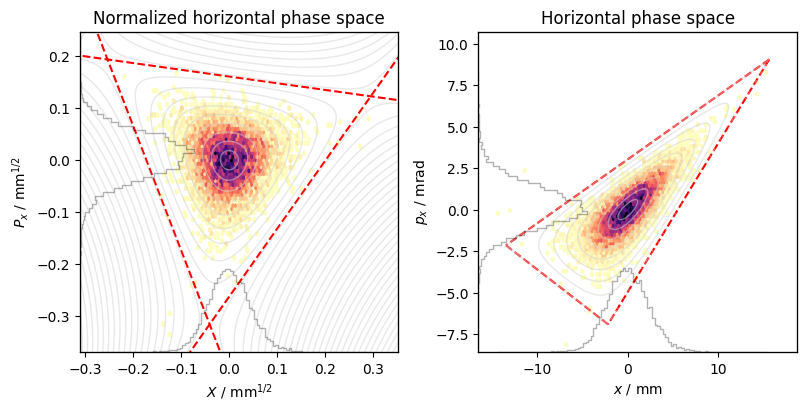

In [5]:
plot = xplt.PhaseSpacePlot(particles, mask=particles.state > 0, kind="X,x", twiss=tw)

# determine the virtual sextupole
S, mu = xplt.util.virtual_sextupole(tracker)

print(f"S = {S:g} m^(-1/2)")
print(f"mu = {mu:g} rad/2pi")

# plot the hamiltonian
plot.plot_hamiltonian_kobayashi(0, S=S, mu=mu, extend=5)
plot.plot_hamiltonian_kobayashi(1, S=S, mu=mu)

-----------------
```{seealso}
- {class}`xplot.phasespace`
```